In [4]:
import jax.numpy as jnp
from utils_v2 import KalmanFilter
import math
import matplotlib.pyplot as plt
import jax.random as jrandom
from time import time

In [15]:
sigma_x = 0.01
sigma_t = 0.01
x_values = jnp.arange(-1, 1, sigma_x)
t_values = jnp.arange(0, 2, sigma_t)
N = len(x_values)
M = len(t_values)
v = 0.001

In [16]:
u = jnp.sin(x_values * 2 * math.pi)
f = jnp.cos(x_values * 4 * math.pi)
nu = jnp.zeros(x_values.shape)

In [17]:
x_0 = jnp.expand_dims(jnp.r_[u, nu], axis=-1)

In [18]:
X = -2 * jnp.ones(u.shape[0])
X = jnp.diag(X)
X += jnp.diag(jnp.ones(u.shape[0] - 1), k=-1) + jnp.diag(jnp.ones(u.shape[0] - 1), k=1)
X /= sigma_x**2


In [19]:
INVS = jnp.linalg.inv(jnp.eye(X.shape[0]) - 0.5 * sigma_t * v * X)

In [20]:
A_n = INVS @ (jnp.eye(X.shape[0]) + 0.5 * sigma_t * v * X)

In [21]:
B_n = INVS * 0.5 * sigma_t

In [22]:
eye = jnp.eye(f.shape[0])
zero = jnp.zeros((f.shape[0], f.shape[0]))
A = jnp.block([[A_n, zero], [zero, eye]])

In [23]:
A.shape

(400, 400)

In [ ]:
B = jnp.block([[B_n], [eye]])

In [ ]:
H = jnp.block([eye, zero])
R = jnp.eye(u.shape[0]) * 0.05
Q = jnp.eye(x_0.shape[0]) * 0.05

P_0 = jnp.ones((x_0.shape[0], x_0.shape[0]))

In [ ]:
def plot(kf: KalmanFilter, iterations: int, plot_each: int = None) -> None:
    plot_each = iterations if plot_each is None else plot_each
    plot_each = min(plot_each, iterations)
    fig, ax = plt.subplots()
    ax.plot(x_values, u, label="True state")
    # ax[1].plot(x_values, nu, label="True state")
    for i in range(1, iterations + 1):
        K = (jnp.linalg.inv(kf.R + kf.B.T @ kf.P @ kf.B)) @ kf.B.T @ kf.P @ kf.A
        kf.predict(-1 * K @ kf.x_k)
        kf.update(x_0)
        if i % plot_each == 0:
            ax.plot(
                x_values,
                kf.x_k[:N],
                label=f"KF estimation after {i} iterations",
            )
            # ax[1].plot(x_values,kf.x_k[2*N : 3 * N],label=f"nu KF estimation after {i} iterations",)

    plt.xlabel("x_n values", fontsize=15)
    plt.ylabel("u_n values", fontsize=15)
    plt.title("Training evolution", fontsize=15)
    ax.legend(fontsize=15)
    fig.set_size_inches(17, 10, forward=True)
    plt.show()

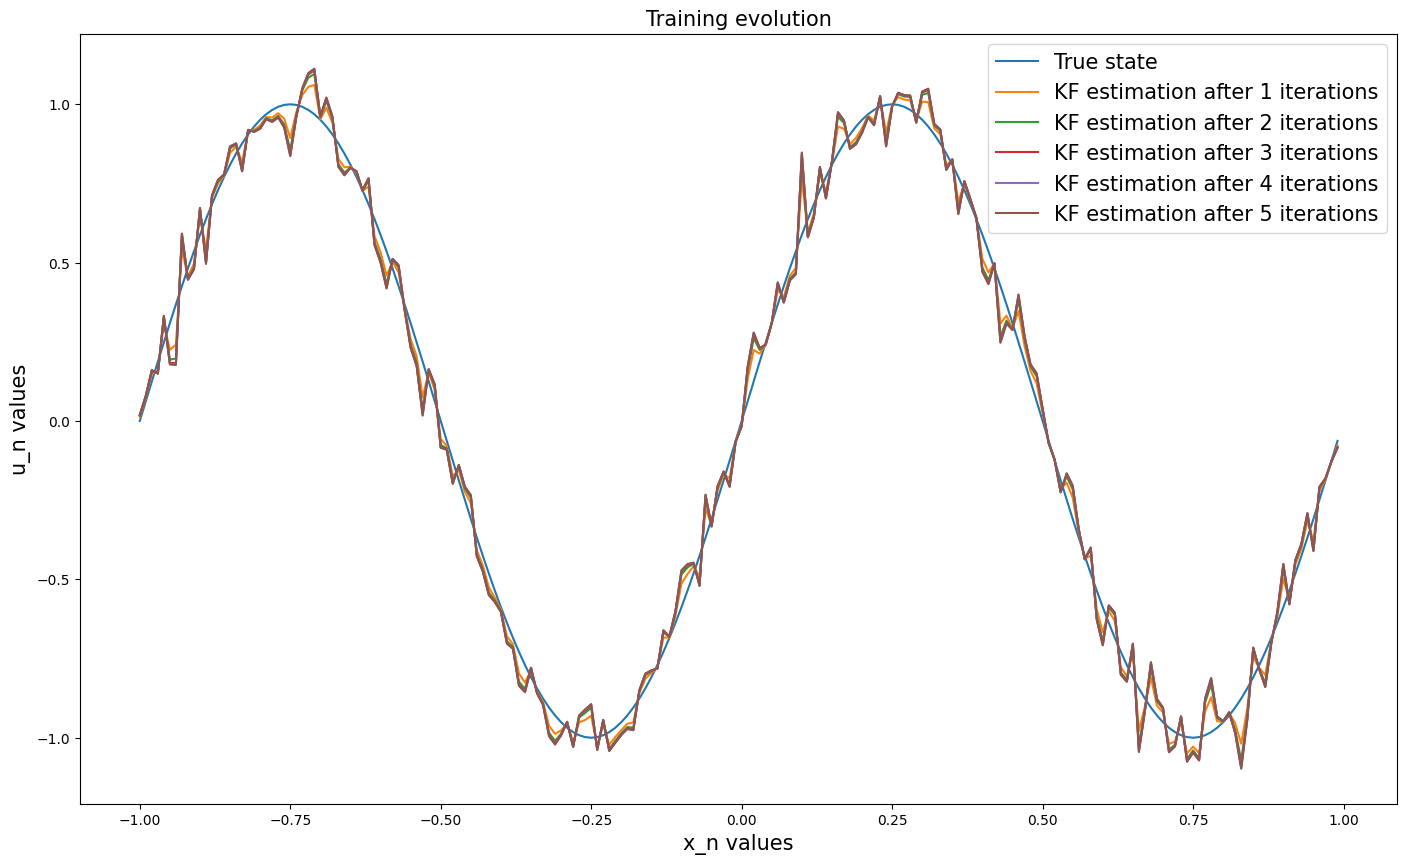

In [28]:
mean = 0
std_dev = 0.05
key = jrandom.PRNGKey(int(time()))
w_k = jrandom.normal(key, shape=(x_0.shape[0], 1)) * std_dev + mean
key = jrandom.PRNGKey(int(time()))
Z = jrandom.normal(key, shape=(u.shape[0], 1)) * std_dev + mean
kf = KalmanFilter(x_0, A, B, H, H, R, Q, Z, w_k, P_0)

plot(kf, iterations=5, plot_each=1)